In [22]:
!pip install seaborn



In [4]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 351.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.3 MB/s eta 0:00:00


In [7]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

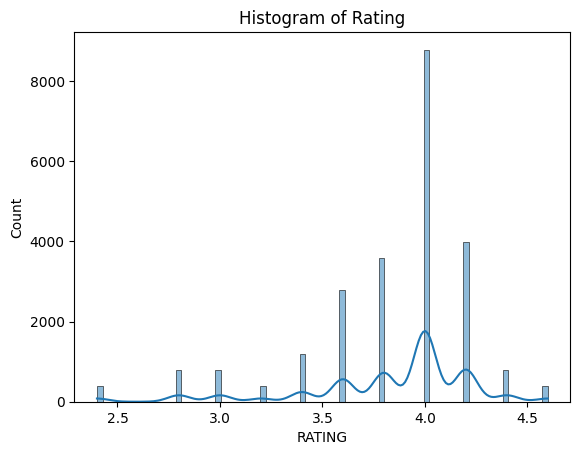

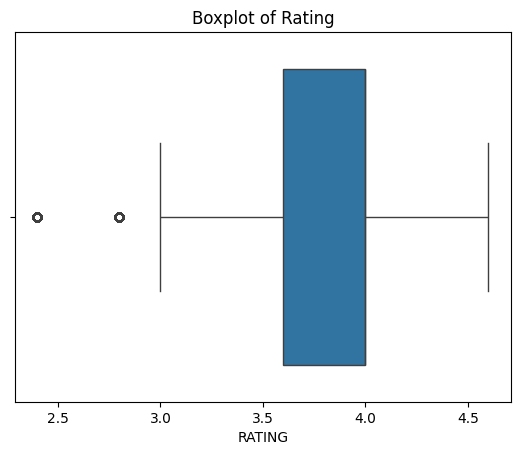

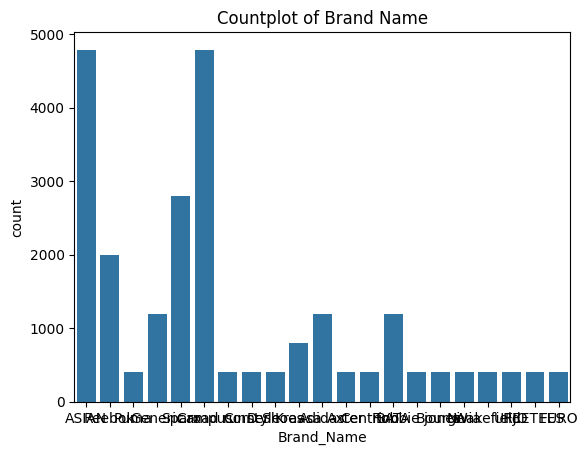

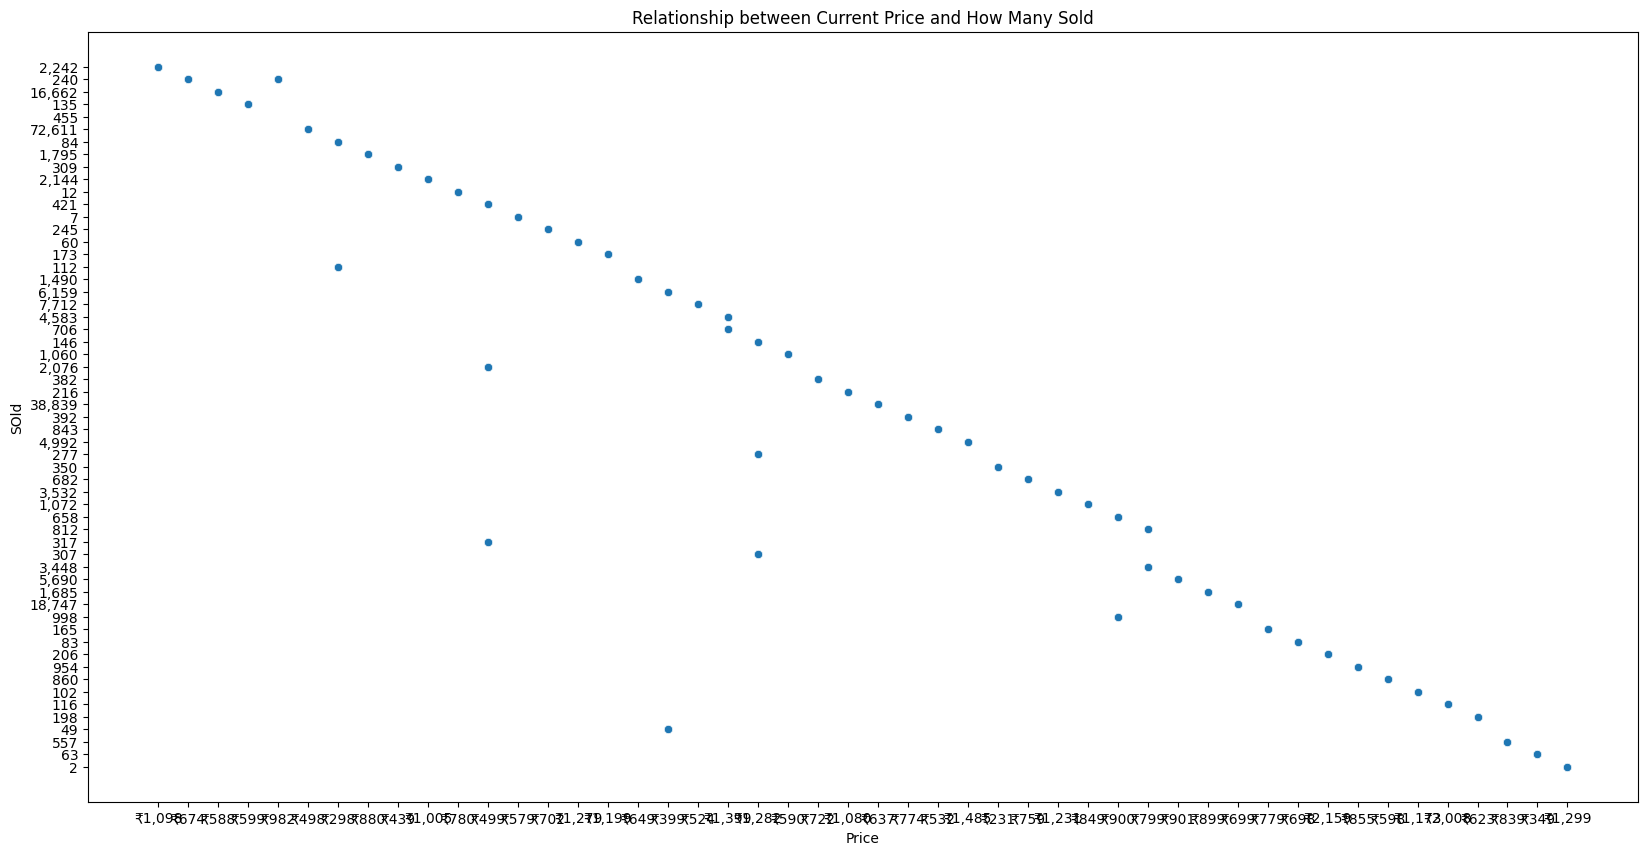

In [8]:
# Membaca data dari file CSV
data = pd.read_csv('/content/sample_data/MEN_SHOES.csv')

# Menampilkan histogram untuk distribusi data numerik
sns.histplot(data['RATING'], kde=True)
plt.title('Histogram of Rating')
plt.show()

# Menampilkan boxplot untuk melihat distribusi dan outlier
sns.boxplot(x=data['RATING'])
plt.title('Boxplot of Rating')
plt.show()

# Menampilkan countplot untuk data kategorikal
sns.countplot(x='Brand_Name', data=data)
plt.title('Countplot of Brand Name')
plt.show()

plt.figure(figsize=(20,10))
sns.scatterplot(x='Current_Price', y='How_Many_Sold', data=data)
plt.title('Relationship between Current Price and How Many Sold')
plt.xlabel('Price')
plt.ylabel('SOld')
plt.show()

In [9]:
# Nilai hilang
def fill_missing_values(data):
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    data[numeric_cols] = data[numeric_cols].apply(lambda col: col.fillna(col.mean()))
    categorical_cols = data.select_dtypes(include=[object]).columns
    data[categorical_cols] = data[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]))
    return data

data = fill_missing_values(data)

# Menghapus duplikat
data = data.drop_duplicates()

# Menentukan fitur kategorikal dan numerik
categorical_features = ['Brand_Name', 'Product_details']
numerical_features = ['How_Many_Sold', 'Current_Price']

# Membersihkan data numerik yang salah format
data['How_Many_Sold'] = data['How_Many_Sold'].str.replace(',', '').astype(float)
data['Current_Price'] = data['Current_Price'].str.replace('[^\d.]', '', regex=True).astype(float)

# Encode the categorical variables
le = LabelEncoder()
data['Brand_Name'] = le.fit_transform(data['Brand_Name'])

In [10]:
# Split the data into features (X) and target (y)
X = data.drop('RATING', axis=1)
y = data['RATING']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Prepare features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [12]:
# Define models to compare
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='linear'),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

results = {}
model_pipelines = {}

In [24]:
# Train and evaluate each model
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    results[model_name] = {
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred_test),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'train_mse': mean_squared_error(y_train, y_pred_train),
        'test_mse': mean_squared_error(y_test, y_pred_test)
    }
    model_pipelines[model_name] = pipeline

In [15]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model
param_grids = {
    'Random Forest': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10]
    },
    'SVR': {
        'regressor__C': [0.1, 1, 10],
        'regressor__epsilon': [0.01, 0.1, 0.2],
        'regressor__kernel': ['linear', 'rbf']
    },
    'KNN': {
        'regressor__n_neighbors': [3, 5, 7, 10],
        'regressor__weights': ['uniform', 'distance'],
        'regressor__p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
    }
}

# Grid search
best_models = {}
for model_name, model in models.items():
    print(f"Performing Grid Search for {model_name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

# Evaluate best models
results_grid = {}
for model_name, model in best_models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    results_grid[model_name] = {
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred_test),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'train_mse': mean_squared_error(y_train, y_pred_train),
        'test_mse': mean_squared_error(y_test, y_pred_test)
    }

# Convert results to DataFrame and print
results_grid_df = pd.DataFrame(results_grid).T
print("### Hasil Evaluasi Model setelah Hyperparameter Tuning ###")
print(results_grid_df)

Performing Grid Search for Random Forest...
Best parameters for Random Forest: {'regressor__max_depth': None, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}
Performing Grid Search for SVR...
Best parameters for SVR: {'regressor__C': 1, 'regressor__epsilon': 0.01, 'regressor__kernel': 'rbf'}
Performing Grid Search for KNN...
Best parameters for KNN: {'regressor__n_neighbors': 5, 'regressor__p': 1, 'regressor__weights': 'uniform'}
### Hasil Evaluasi Model setelah Hyperparameter Tuning ###
               train_r2   test_r2  train_rmse  test_rmse  train_mse  test_mse
Random Forest  0.864638  0.479108    0.154225   0.279265   0.023785  0.077989
SVR            0.978721  0.342350    0.061149   0.313791   0.003739  0.098465
KNN            0.639266  0.113915    0.251768   0.364234   0.063387  0.132667


Evaluating Random Forest...
Evaluating SVR...
Evaluating KNN...
### Hasil Evaluasi Cross-Validation ###
               mean_test_r2  std_test_r2  mean_test_rmse
Random Forest      0.450964     0.204025        0.298928
SVR                0.348810     0.191253        0.329705
KNN                0.387712     0.267348        0.314510


/tmp/ipython-input-1615711856.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cv_results_df.index, y='mean_test_r2', data=cv_results_df, palette='viridis')
/tmp/ipython-input-1615711856.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cv_results_df.index, y='mean_test_rmse', data=cv_results_df, palette='viridis')


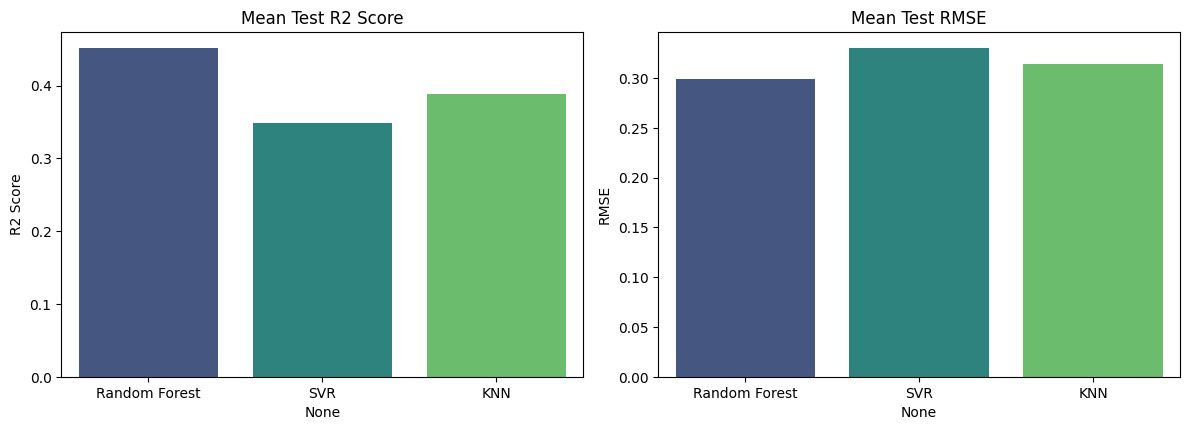

In [17]:
# Evaluate each model using cross-validation
from sklearn.model_selection import cross_validate

cv_results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    print(f"Evaluating {model_name}...")
    scores = cross_validate(pipeline, X, y, cv=5,
                            scoring=['r2', 'neg_mean_squared_error'],
                            return_train_score=False)

    cv_results[model_name] = {
        'mean_test_r2': np.mean(scores['test_r2']),
        'std_test_r2': np.std(scores['test_r2']),
        'mean_test_rmse': np.sqrt(-np.mean(scores['test_neg_mean_squared_error']))
    }

# Convert results to DataFrame
cv_results_df = pd.DataFrame(cv_results).T

print("### Hasil Evaluasi Cross-Validation ###")
print(cv_results_df)

# Plot results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

# Plot R2 Scores
plt.subplot(2, 2, 1)
sns.barplot(x=cv_results_df.index, y='mean_test_r2', data=cv_results_df, palette='viridis')
plt.title('Mean Test R2 Score')
plt.ylabel('R2 Score')

# Plot RMSE
plt.subplot(2, 2, 2)
sns.barplot(x=cv_results_df.index, y='mean_test_rmse', data=cv_results_df, palette='viridis')
plt.title('Mean Test RMSE')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()

In [25]:
# Determine the best model based on the smallest RMSE on test data
best_model_name = results_df['test_rmse'].idxmin()
best_model_rmse = results_df.loc[best_model_name, 'test_rmse']

# Save the best model using joblib
joblib_file = f"best_model.sav"
joblib.dump(model_pipelines[best_model_name], joblib_file)

['best_model.sav']

In [21]:
# Determine the best model based on the smallest RMSE on test data
best_model_name = results_grid_df['test_rmse'].idxmin()
best_model_rmse = results_grid_df.loc[best_model_name, 'test_rmse']

# Save the best model using joblib
joblib_file = f"best_model.sav"
joblib.dump(model_pipelines[best_model_name], joblib_file)

print(f"Best model saved: {best_model_name} with RMSE: {best_model_rmse:.4f}")

Best model saved: Random Forest with RMSE: 0.2793
